#  XGBoost implementation, visualization, and predicting the champion of the 2025-2026 season

In [27]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# load data

ds = load_dataset("dlpacoos/CS506_NBA", data_files="team_season_features_v2_clean-2.csv")
features_df = ds["train"].to_pandas()

num_cols = features_df.select_dtypes(include="number").columns.tolist()
for col in ["champion", "season"]:
    if col in num_cols:
        num_cols.remove(col)

print("Creating season-relative features...")
for col in num_cols:
    features_df[f'{col}_season_rank'] = features_df.groupby('season')[col].rank(pct=True)
    features_df[f'{col}_season_zscore'] = features_df.groupby('season')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# update feature list
num_cols_extended = features_df.select_dtypes(include="number").columns.tolist()
for col in ["champion", "season"]:
    if col in num_cols_extended:
        num_cols_extended.remove(col)

X = features_df[num_cols_extended].copy()
X = X.replace([np.inf, -np.inf], np.nan)
y = features_df["champion"].astype(int)

# train/test split by season
train_mask = features_df["season"] <= 2015
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

id_test = features_df.loc[~train_mask, ["season", "team", "champion"]].copy()

# prepare groups for ranking (each season is a group)
train_groups = features_df[train_mask].groupby('season').size().values
test_groups = features_df[~train_mask].groupby('season').size().values

# preprocessing
preprocessor = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# train XGBRanker - the best model for "pick top team from each season"
print("\nTraining XGBRanker...")

ranker = xgb.XGBRanker(
    objective='rank:pairwise',
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

ranker.fit(X_train_prep, y_train, group=train_groups)
ranking_scores = ranker.predict(X_test_prep)

print("\n" + "="*60)
print("MODEL RESULTS")
print("="*60)

# add scores to test data
id_test["ranking_score"] = ranking_scores

# get predicted champion for each season (highest score)
idx_rank = id_test.groupby("season")["ranking_score"].idxmax()

predicted_champs = (
    id_test.loc[idx_rank, ["season", "team", "ranking_score"]]
           .rename(columns={"team": "team_pred", "ranking_score": "pred_score"})
           .reset_index(drop=True)
)

true_champs = (
    id_test.loc[id_test["champion"] == 1, ["season", "team"]]
           .rename(columns={"team": "team_true"})
           .reset_index(drop=True)
)

eval_results = predicted_champs.merge(true_champs, on="season", suffixes=("_pred", "_true"))
eval_results["correct"] = (eval_results["team_pred"] == eval_results["team_true"]).astype(int)

# calculate metrics
id_test['rank'] = id_test.groupby('season')['ranking_score'].rank(ascending=False, method='first')
true_champ_ranks = id_test[id_test['champion'] == 1]['rank']

print(f"Top-1 Accuracy: {eval_results['correct'].mean():.4f}")
print(f"Top-2 Accuracy: {(true_champ_ranks <= 2).mean():.4f}")
print(f"Top-4 Accuracy: {(true_champ_ranks <= 4).mean():.4f}")

print(f"\nMean Reciprocal Rank: {(1 / true_champ_ranks).mean():.4f}")
print(f"Average rank of true champions: {true_champ_ranks.mean():.2f}")

# average precision (ranking quality metric)
print(f"\nAverage Precision: {average_precision_score(y_test, ranking_scores):.4f}")

print("\nPredicted vs. True Champions by Season:\n")
print(eval_results[["season", "team_pred", "team_true", "pred_score", "correct"]]
      .sort_values("season")
      .to_string(index=False))

team_season_features_v2_clean-2.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Creating season-relative features...

Training XGBRanker...

MODEL RESULTS
Top-1 Accuracy: 0.7000
Top-2 Accuracy: 0.9000
Top-4 Accuracy: 1.0000

Mean Reciprocal Rank: 0.8250
Average rank of true champions: 1.50

Average Precision: 0.7860

Predicted vs. True Champions by Season:

 season team_pred team_true  pred_score  correct
   2016  Warriors Cavaliers    2.911292        0
   2017  Warriors  Warriors    2.927099        1
   2018  Warriors  Warriors    2.570243        1
   2019   Raptors   Raptors    3.098421        1
   2020     Bucks    Lakers   -0.853212        0
   2021  Clippers     Bucks   -0.050978        0
   2022  Warriors  Warriors    1.315036        1
   2023   Nuggets   Nuggets    1.865657        1
   2024   Celtics   Celtics    3.425000        1
   2025   Thunder   Thunder    3.356454        1


# Visualizations from the XGBRanker model

/tmp/ipython-input-4070996690.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


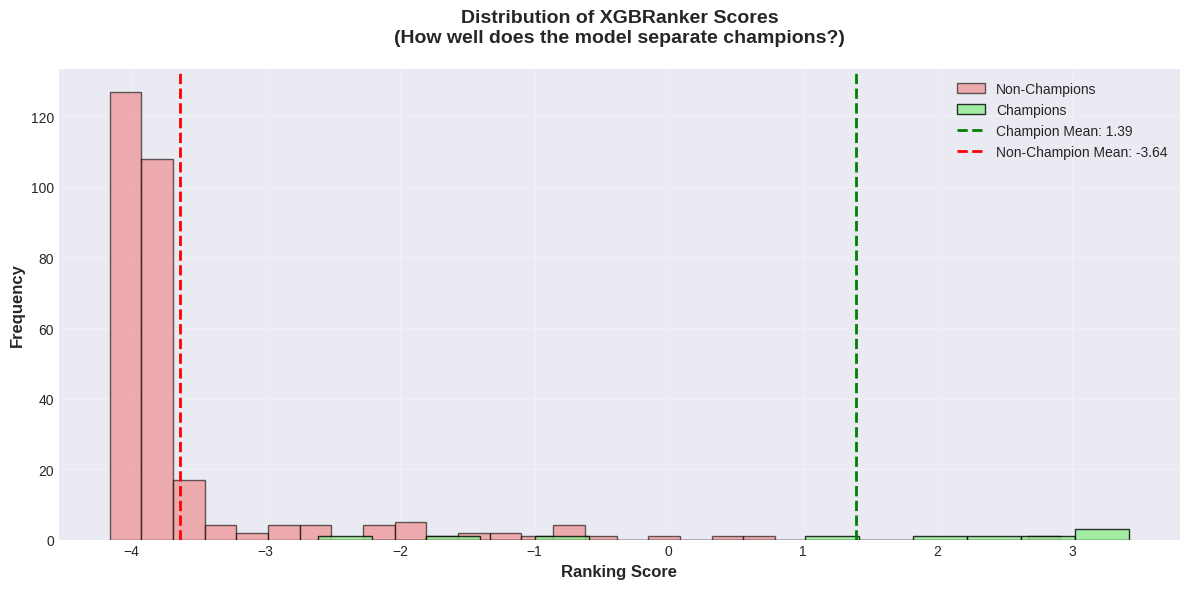

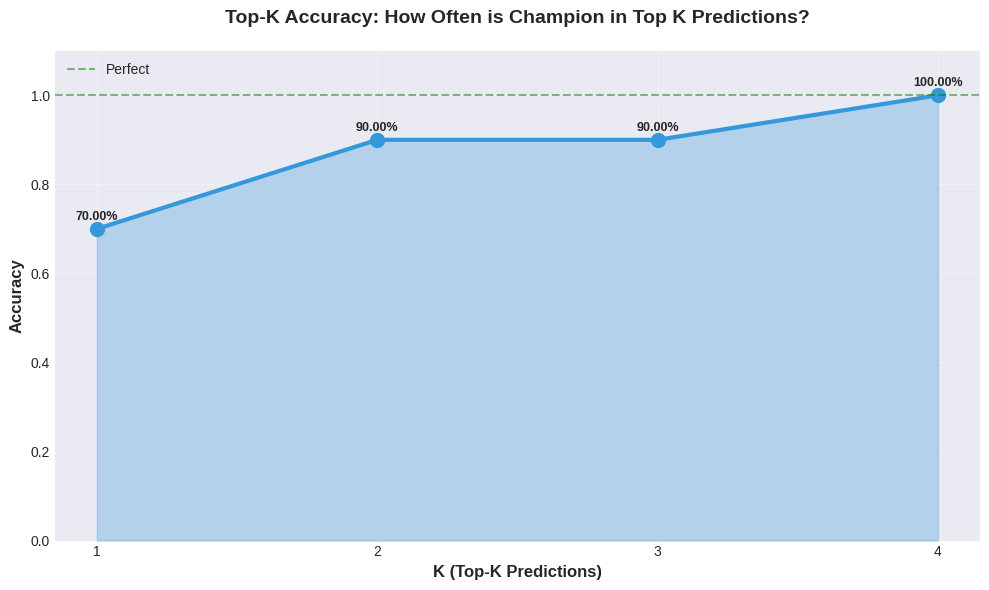

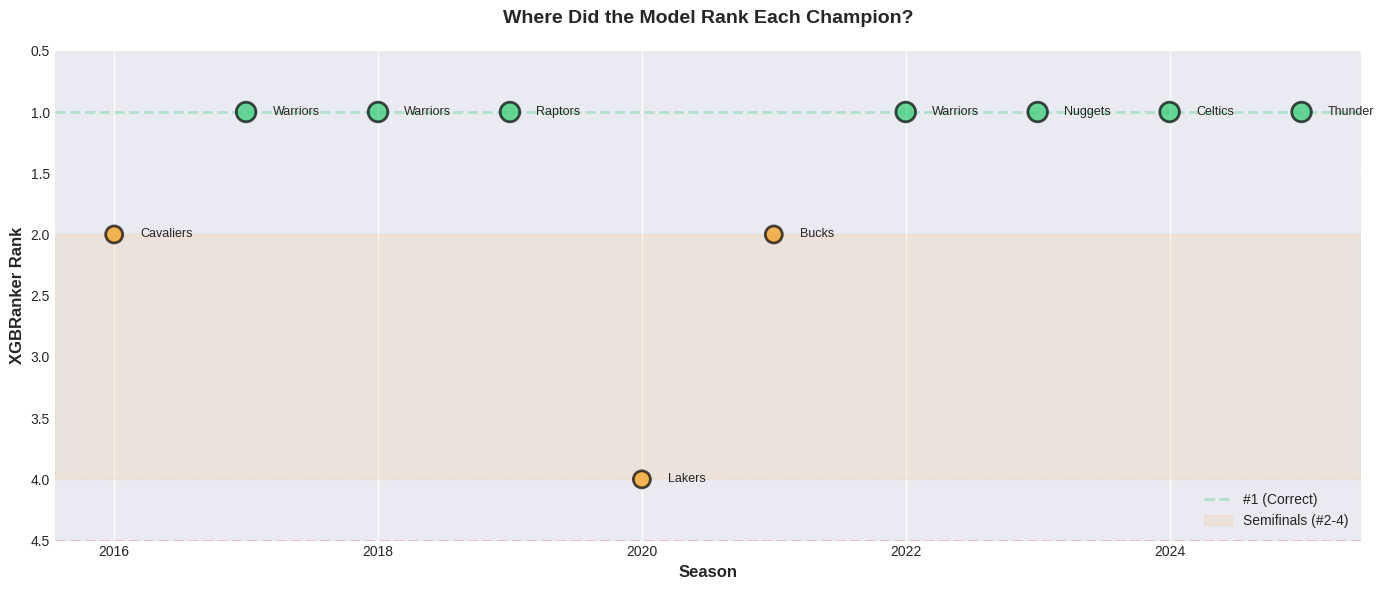

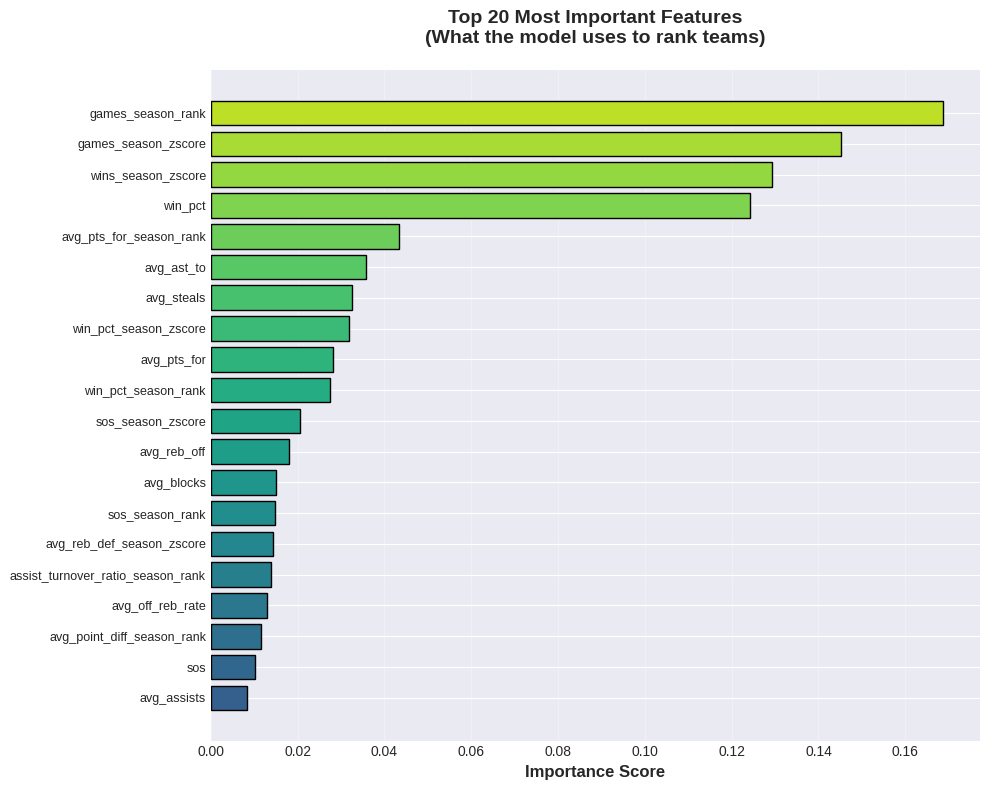

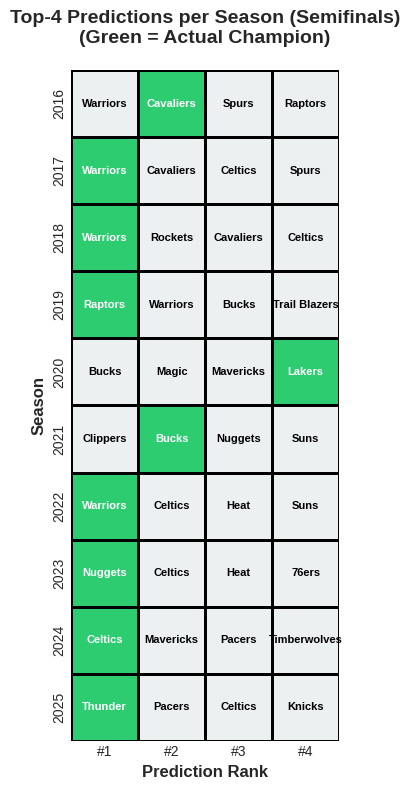

In [28]:


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(12, 6))

seasons = sorted(eval_results['season'].unique())
correct = eval_results.set_index('season')['correct']

# bar chart with colors
colors = ['#2ecc71' if c == 1 else '#e74c3c' for c in correct]
bars = ax.bar(seasons, [1]*len(seasons), color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# add team names on bars
for i, (season, row) in enumerate(eval_results.iterrows()):
    # predicted team
    ax.text(season, 0.5, f"Predicted:\n{row['team_pred']}",
            ha='center', va='center', fontsize=9, fontweight='bold')
    # actual team if wrong
    if row['correct'] == 0:
        ax.text(season, 0.85, f"(Actual: {row['team_true']})",
                ha='center', va='center', fontsize=8, style='italic', color='darkred')

ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Result', fontsize=12, fontweight='bold')
ax.set_title('Championship Predictions by Season\n(Green = Correct, Red = Incorrect)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_yticks([0, 1])
ax.set_yticklabels(['', 'Prediction'])
ax.grid(axis='y', alpha=0.3)

# add accuracy text
accuracy = eval_results['correct'].mean()
ax.text(0.02, 0.98, f'Overall Accuracy: {accuracy:.1%}',
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        verticalalignment='top')

plt.tight_layout()
plt.show()

# 2. Score Distribution: Champions vs Non-Champions

fig, ax = plt.subplots(figsize=(12, 6))

# separate scores
champion_scores = id_test[id_test['champion'] == 1]['ranking_score']
non_champion_scores = id_test[id_test['champion'] == 0]['ranking_score']

# create histograms
ax.hist(non_champion_scores, bins=30, alpha=0.6, label='Non-Champions', color='lightcoral', edgecolor='black')
ax.hist(champion_scores, bins=15, alpha=0.8, label='Champions', color='lightgreen', edgecolor='black')

# add vertical lines for means
ax.axvline(champion_scores.mean(), color='green', linestyle='--', linewidth=2,
           label=f'Champion Mean: {champion_scores.mean():.2f}')
ax.axvline(non_champion_scores.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Non-Champion Mean: {non_champion_scores.mean():.2f}')

ax.set_xlabel('Ranking Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of XGBRanker Scores\n(How well does the model separate champions?)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Top-K Accuracy Curve
fig, ax = plt.subplots(figsize=(10, 6))

k_values = [1, 2, 3, 4]
accuracies = [(true_champ_ranks <= k).mean() for k in k_values]

ax.plot(k_values, accuracies, marker='o', linewidth=3, markersize=10, color='#3498db')
ax.fill_between(k_values, accuracies, alpha=0.3, color='#3498db')

# add value labels on points
for k, acc in zip(k_values, accuracies):
    ax.text(k, acc + 0.02, f'{acc:.2%}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('K (Top-K Predictions)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Top-K Accuracy: How Often is Champion in Top K Predictions?',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(k_values)
ax.set_ylim([0, 1.1])
ax.grid(alpha=0.3)
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect')
ax.legend()

plt.tight_layout()
plt.show()

# 4. Champion Ranking Position
fig, ax = plt.subplots(figsize=(14, 6))

# get champion data
champion_data = id_test[id_test['champion'] == 1][['season', 'team', 'rank']].copy()
champion_data = champion_data.sort_values('season')

# create scatter plot instead of bars
colors = ['#2ecc71' if r == 1 else '#f39c12' if 2 <= r <= 4 else '#e74c3c'
          for r in champion_data['rank']]
sizes = [200 if r == 1 else 150 for r in champion_data['rank']]

ax.scatter(champion_data['season'], champion_data['rank'],
           c=colors, s=sizes, alpha=0.7, edgecolors='black', linewidth=2, zorder=3)

# add team labels next to points
for idx, row in champion_data.iterrows():
    ax.text(row['season'] + 0.2, row['rank'], row['team'],
            fontsize=9, va='center')

# add horizontal reference lines
ax.axhline(y=1, color='#2ecc71', linestyle='--', alpha=0.3, linewidth=2, label='#1 (Correct)')
ax.axhspan(2, 4, alpha=0.1, color='#f39c12', label='Semifinals (#2-4)')
ax.axhline(y=4.5, color='#e74c3c', linestyle='--', alpha=0.3, linewidth=2)

ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_ylabel('XGBRanker Rank', fontsize=12, fontweight='bold')
ax.set_title('Where Did the Model Rank Each Champion?',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0.5, max(champion_data['rank']) + 0.5)
ax.invert_yaxis()  # rank 1 at top
ax.grid(axis='y', alpha=0.3, linestyle=':')
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


# 5. Feature Importance


fig, ax = plt.subplots(figsize=(10, 8))

feature_importance = ranker.feature_importances_
importance_df = pd.DataFrame({
    'feature': num_cols_extended,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# take top 20
top_features = importance_df.tail(20)

# create horizontal bar chart
bars = ax.barh(range(len(top_features)), top_features['importance'],
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features))),
               edgecolor='black', linewidth=1)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=9)
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Important Features\n(What the model uses to rank teams)',
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#6. A table showing the models top 4 predicted teams for the past 10 seasons

fig, ax = plt.subplots(figsize=(14, 8))

# for each season, get top 4 predictions
top4_per_season = []
for season in sorted(id_test['season'].unique()):
    season_data = id_test[id_test['season'] == season].copy()
    season_data = season_data.sort_values('ranking_score', ascending=False).head(4)

    actual_champ = id_test[(id_test['season'] == season) & (id_test['champion'] == 1)]['team'].values[0]

    for rank, (idx, row) in enumerate(season_data.iterrows(), 1):
        top4_per_season.append({
            'season': season,
            'rank': rank,
            'team': row['team'],
            'is_champion': row['team'] == actual_champ
        })

df_viz = pd.DataFrame(top4_per_season)

# pivot for heatmap
pivot = df_viz.pivot_table(index='season', columns='rank', values='is_champion', aggfunc='max')
pivot_teams = df_viz.pivot_table(index='season', columns='rank', values='team', aggfunc='first')

# create custom colormap
data_for_plot = pivot.fillna(False).astype(bool)

# plot heatmap
sns.heatmap(data_for_plot, cmap=['#ecf0f1', '#2ecc71'], cbar=False,
            linewidths=2, linecolor='black', square=True, ax=ax, annot=False)

# add team names as text annotations
for i, season in enumerate(pivot_teams.index):
    for j, rank in enumerate(pivot_teams.columns):
        team_name = pivot_teams.loc[season, rank]
        is_champ = data_for_plot.iloc[i, j]

        # abbreviate long team names
        if len(team_name) > 20:
            team_name = team_name[:17] + '...'

        color = 'white' if is_champ else 'black'
        ax.text(j + 0.5, i + 0.5, team_name,
                ha='center', va='center', fontsize=8, fontweight='bold', color=color)

ax.set_xlabel('Prediction Rank', fontsize=12, fontweight='bold')
ax.set_ylabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Top-4 Predictions per Season (Semifinals)\n(Green = Actual Champion)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticklabels(['#1', '#2', '#3', '#4'], fontsize=10)

plt.tight_layout()
plt.show()



# Making predictions on this seasons rankings and champion

In [29]:

# Load current season data (2025-2026)

ds = load_dataset("dlpacoos/CS506_NBA", data_files="2026_stats_december.csv")
current_season = ds["train"].to_pandas()
print("="*80)
print("2025-2026 SEASON PREDICTION")
print("="*80)
print(f"\nLoaded {len(current_season)} teams for prediction")

# Create season-relative features for current season (same as training)
print("\nCreating season-relative features for current season...")

for col in num_cols:
    if col in current_season.columns:
        # Rank within current season (percentile)
        current_season[f'{col}_season_rank'] = current_season[col].rank(pct=True)

        # Z-score within current season
        col_mean = current_season[col].mean()
        col_std = current_season[col].std()
        if col_std > 0:
            current_season[f'{col}_season_zscore'] = (current_season[col] - col_mean) / col_std
        else:
            current_season[f'{col}_season_zscore'] = 0
    else:
        # If column is missing, add with default values
        print(f"Warning: {col} not found in current season data, using 0")
        current_season[col] = 0
        current_season[f'{col}_season_rank'] = 0.5
        current_season[f'{col}_season_zscore'] = 0

# Prepare features (use same extended features as training)
X_current = current_season[num_cols_extended].copy()
X_current = X_current.replace([np.inf, -np.inf], np.nan)

# Apply the same preprocessing
X_current_prep = preprocessor.transform(X_current)

# Make predictions using the trained ranker
print("\nGenerating championship predictions...")
ranking_scores_2026 = ranker.predict(X_current_prep)

# Create results dataframe
results_2026 = pd.DataFrame({
    'team': current_season['team'],
    'ranking_score': ranking_scores_2026,
    'win_pct': current_season['win_pct'],
    'wins': current_season['wins'],
    'games': current_season['games'],
    'avg_point_diff': current_season['avg_point_diff']
})

# Sort by ranking score (highest = most likely champion)
results_2026 = results_2026.sort_values('ranking_score', ascending=False).reset_index(drop=True)
results_2026['rank'] = range(1, len(results_2026) + 1)

print("\n" + "="*80)
print("PREDICTED TOP 4 CHAMPIONSHIP CONTENDERS - 2025-2026 SEASON")
print("="*80)

top4 = results_2026.head(4)
for idx, row in top4.iterrows():
    print(f"\n{row['rank']}. {row['team']}")
    print(f"   Championship Probability Score: {row['ranking_score']:.4f}")
    print(f"   Current Record: {int(row['wins'])}-{int(row['games'] - row['wins'])} ({row['win_pct']:.3f})")
    print(f"   Point Differential: {row['avg_point_diff']:+.1f}")

print("\n" + "="*80)
print("FULL RANKINGS")
print("="*80)
print(results_2026[['rank', 'team', 'ranking_score', 'win_pct', 'avg_point_diff']].to_string(index=False))


# Compare predictions with current standings
print("\n" + "="*80)
print("MODEL PREDICTIONS vs CURRENT WIN%")
print("="*80)
comparison = results_2026[['rank', 'team', 'ranking_score', 'win_pct', 'wins']].head(10)
print(comparison.to_string(index=False))

2026_stats_december.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

2025-2026 SEASON PREDICTION

Loaded 30 teams for prediction

Creating season-relative features for current season...

Generating championship predictions...

PREDICTED TOP 4 CHAMPIONSHIP CONTENDERS - 2025-2026 SEASON

1. Thunder
   Championship Probability Score: -0.8987
   Current Record: 23-1 (0.958)
   Point Differential: +16.2

2. Raptors
   Championship Probability Score: -2.2612
   Current Record: 15-11 (0.577)
   Point Differential: +1.9

3. Rockets
   Championship Probability Score: -3.1591
   Current Record: 15-6 (0.714)
   Point Differential: +10.6

4. Pistons
   Championship Probability Score: -3.3577
   Current Record: 19-5 (0.792)
   Point Differential: +5.5

FULL RANKINGS
 rank          team  ranking_score  win_pct  avg_point_diff
    1       Thunder      -0.898707    0.958            16.2
    2       Raptors      -2.261160    0.577             1.9
    3       Rockets      -3.159140    0.714            10.6
    4       Pistons      -3.357676    0.792             5.5
    5